# 🔍 Diagnóstico de Bias Correction - RSDS

Este notebook verifica si el bias correction de radiación solar (rsds) se aplicó correctamente comparando:

1. **Datos originales** vs **datos corregidos**
2. **Distribuciones estadísticas** (cuantiles, media, std)
3. **Series temporales** espacialmente agregadas
4. **Mapas espaciales** de diferencias

## 🎯 Problema a diagnosticar:
Reportas que los datos "aparecen iguales" después del bias correction. Vamos a verificar:
- ¿Se aplicó realmente la corrección?
- ¿Los parámetros de QM se entrenaron correctamente?
- ¿Hay diferencias significativas entre original y corregido?

In [1]:
# ============================================================
# 📦 IMPORTS Y CONFIGURACIÓN
# ============================================================

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de plotting
plt.rcParams['figure.figsize'] = (15, 8)
sns.set_style('whitegrid')

print("✅ Imports completados")

✅ Imports completados


In [5]:
# ============================================================
# 📁 DEFINIR RUTAS DE ARCHIVOS
# ============================================================

base_dir = Path("/home/aninotna/magister/tesis/justh2_pipeline")
data_dir = base_dir / "data/cmip6"

# Referencia (observaciones)
obs_path = base_dir / "data/solar/solar_diario_grilla.zarr"

# Datos originales (CMIP6 crudo)
historical_orig_pattern = data_dir / "rsds/historical/rsds_Amon_access_cm2_historical*.nc"
ssp245_orig_pattern = data_dir / "rsds/ssp245/access_cm2/*.nc"

# Datos corregidos - MÉTODO 1 (factores multiplicativos)
ssp245_bc_method1 = data_dir / "rsds/bias_corrected/rsds_bc_Amon_access_cm2_ssp245.nc"

# Datos corregidos - MÉTODO 2 (Quantile Mapping real)
historical_qm = data_dir / "rsds/bias_corrected_qm/rsds_qm_access_historical.nc"
ssp245_qm = data_dir / "rsds/bias_corrected_qm/rsds_qm_access_ssp245.nc"

print("📁 Rutas configuradas:")
print(f"   • Observaciones: {obs_path}")
print(f"   • Historical original: {historical_orig_pattern}")
print(f"   • SSP245 original: {ssp245_orig_pattern}")
print(f"   • SSP245 BC (método 1): {ssp245_bc_method1}")
print(f"   • SSP245 QM (método 2): {ssp245_qm}")

📁 Rutas configuradas:
   • Observaciones: /home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr
   • Historical original: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds/historical/rsds_Amon_access_cm2_historical*.nc
   • SSP245 original: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds/ssp245/access_cm2/*.nc
   • SSP245 BC (método 1): /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds/bias_corrected/rsds_bc_Amon_access_cm2_ssp245.nc
   • SSP245 QM (método 2): /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds/bias_corrected_qm/rsds_qm_access_ssp245.nc


In [3]:
# ============================================================
# 📊 CARGAR DATOS - OBSERVACIONES
# ============================================================

print("\n📊 Cargando observaciones (GHI diario → mensual)...")

# Abrir zarr de observaciones
obs_ds = xr.open_zarr(obs_path)

# Verificar nombre de variable
if "ghi" in obs_ds:
    obs_daily = obs_ds["ghi"]
elif "rsds" in obs_ds:
    obs_daily = obs_ds["rsds"]
else:
    print(f"❌ Variables disponibles: {list(obs_ds.data_vars)}")
    raise KeyError("No se encontró 'ghi' ni 'rsds' en observaciones")

# Renombrar dimensión de tiempo si es necesario
if "date" in obs_daily.dims:
    obs_daily = obs_daily.rename({"date": "time"})

# Convertir a mensual (promedio mensual)
obs_monthly = obs_daily.resample(time="MS").mean("time", skipna=True)

# Período de calibración (2004-2014)
obs_calib = obs_monthly.sel(time=slice("2004-01-01", "2014-12-31"))

print(f"✅ Observaciones cargadas:")
print(f"   • Shape: {obs_monthly.shape}")
print(f"   • Período completo: {obs_monthly.time.min().values} a {obs_monthly.time.max().values}")
print(f"   • Período calibración: {obs_calib.time.min().values} a {obs_calib.time.max().values}")
print(f"   • Media espacial (2004-2014): {float(obs_calib.mean()):.2f} W/m²")


📊 Cargando observaciones (GHI diario → mensual)...
✅ Observaciones cargadas:
   • Shape: (156, 20, 20)
   • Período completo: 2004-01-01T00:00:00.000000000 a 2016-12-01T00:00:00.000000000
   • Período calibración: 2004-01-01T00:00:00.000000000 a 2014-12-01T00:00:00.000000000
   • Media espacial (2004-2014): 225.47 W/m²


In [6]:
# ============================================================
# 📊 CARGAR DATOS - HISTORICAL ORIGINAL
# ============================================================

print("\n📊 Cargando CMIP6 historical (original)...")

import glob
hist_files = sorted(glob.glob(str(historical_orig_pattern)))

if not hist_files:
    print(f"❌ No se encontraron archivos en {historical_orig_pattern}")
else:
    print(f"   Archivos encontrados: {len(hist_files)}")
    for f in hist_files:
        print(f"     - {Path(f).name}")
    
    # Abrir con open_mfdataset
    hist_orig_ds = xr.open_mfdataset(hist_files, combine="by_coords")
    hist_orig = hist_orig_ds["rsds"]
    
    # Si es diario, convertir a mensual
    if len(hist_orig.time) > 2000:  # probablemente diario
        print("   ⚠️ Datos parecen ser diarios, convirtiendo a mensual...")
        hist_orig = hist_orig.resample(time="MS").mean("time", skipna=True)
    
    # Período de calibración
    hist_calib = hist_orig.sel(time=slice("2004-01-01", "2014-12-31"))
    
    print(f"\n✅ Historical original cargado:")
    print(f"   • Shape: {hist_orig.shape}")
    print(f"   • Período: {hist_orig.time.min().values} a {hist_orig.time.max().values}")
    print(f"   • Media espacial (2004-2014): {float(hist_calib.mean()):.2f} W/m²")


📊 Cargando CMIP6 historical (original)...
   Archivos encontrados: 1
     - rsds_Amon_access_cm2_historical_r1i1p1f1_gn_185001-201412.nc

✅ Historical original cargado:
   • Shape: (1980, 144, 192)
   • Período: 1850-01-16T12:00:00.000000000 a 2014-12-16T12:00:00.000000000
   • Media espacial (2004-2014): 166.44 W/m²


In [7]:
# ============================================================
# 📊 CARGAR DATOS - HISTORICAL CORREGIDO (QM)
# ============================================================

print("\n📊 Cargando CMIP6 historical corregido (Quantile Mapping)...")

if historical_qm.exists():
    hist_qm = xr.open_dataset(historical_qm)["rsds"]
    hist_qm_calib = hist_qm.sel(time=slice("2004-01-01", "2014-12-31"))
    
    print(f"✅ Historical QM cargado:")
    print(f"   • Shape: {hist_qm.shape}")
    print(f"   • Período: {hist_qm.time.min().values} a {hist_qm.time.max().values}")
    print(f"   • Media espacial (2004-2014): {float(hist_qm_calib.mean()):.2f} W/m²")
else:
    print(f"❌ No se encontró {historical_qm}")
    hist_qm = None


📊 Cargando CMIP6 historical corregido (Quantile Mapping)...
✅ Historical QM cargado:
   • Shape: (1980, 20, 20)
   • Período: 1850-01-16T12:00:00.000000000 a 2014-12-16T12:00:00.000000000
   • Media espacial (2004-2014): 225.27 W/m²


In [8]:
# ============================================================
# 📊 CARGAR DATOS - SSP245 ORIGINAL
# ============================================================

print("\n📊 Cargando CMIP6 SSP245 (original)...")

ssp_files = sorted(glob.glob(str(ssp245_orig_pattern)))

if not ssp_files:
    print(f"❌ No se encontraron archivos en {ssp245_orig_pattern}")
    ssp_orig = None
else:
    print(f"   Archivos encontrados: {len(ssp_files)}")
    
    # Abrir con open_mfdataset
    ssp_orig_ds = xr.open_mfdataset(ssp_files, combine="by_coords")
    ssp_orig = ssp_orig_ds["rsds"]
    
    # Si es diario, convertir a mensual
    if len(ssp_orig.time) > 2000:
        print("   ⚠️ Datos parecen ser diarios, convirtiendo a mensual...")
        ssp_orig = ssp_orig.resample(time="MS").mean("time", skipna=True)
    
    print(f"\n✅ SSP245 original cargado:")
    print(f"   • Shape: {ssp_orig.shape}")
    print(f"   • Período: {ssp_orig.time.min().values} a {ssp_orig.time.max().values}")
    print(f"   • Media espacial (2023-2050): {float(ssp_orig.sel(time=slice('2023','2050')).mean()):.2f} W/m²")


📊 Cargando CMIP6 SSP245 (original)...
   Archivos encontrados: 1

✅ SSP245 original cargado:
   • Shape: (1032, 144, 192)
   • Período: 2015-01-16T12:00:00.000000000 a 2100-12-16T12:00:00.000000000
   • Media espacial (2023-2050): 166.83 W/m²


In [9]:
# ============================================================
# 📊 CARGAR DATOS - SSP245 CORREGIDOS
# ============================================================

print("\n📊 Cargando CMIP6 SSP245 corregidos...")

# Método 1: Factores multiplicativos
if ssp245_bc_method1.exists():
    ssp_bc1 = xr.open_dataarray(ssp245_bc_method1)
    print(f"✅ SSP245 BC (Método 1 - factores) cargado:")
    print(f"   • Shape: {ssp_bc1.shape}")
    print(f"   • Período: {ssp_bc1.time.min().values} a {ssp_bc1.time.max().values}")
    print(f"   • Media espacial (2023-2050): {float(ssp_bc1.sel(time=slice('2023','2050')).mean()):.2f} W/m²")
else:
    print(f"❌ No se encontró {ssp245_bc_method1}")
    ssp_bc1 = None

# Método 2: Quantile Mapping
if ssp245_qm.exists():
    ssp_qm = xr.open_dataset(ssp245_qm)["rsds"]
    print(f"\n✅ SSP245 QM (Método 2 - Quantile Mapping) cargado:")
    print(f"   • Shape: {ssp_qm.shape}")
    print(f"   • Período: {ssp_qm.time.min().values} a {ssp_qm.time.max().values}")
    print(f"   • Media espacial (2023-2050): {float(ssp_qm.sel(time=slice('2023','2050')).mean()):.2f} W/m²")
else:
    print(f"❌ No se encontró {ssp245_qm}")
    ssp_qm = None


📊 Cargando CMIP6 SSP245 corregidos...
✅ SSP245 BC (Método 1 - factores) cargado:
   • Shape: (1032, 20, 20)
   • Período: 2015-01-01T00:00:00.000000000 a 2100-12-01T00:00:00.000000000
   • Media espacial (2023-2050): 222.07 W/m²

✅ SSP245 QM (Método 2 - Quantile Mapping) cargado:
   • Shape: (936, 20, 20)
   • Período: 2023-01-16T12:00:00.000000000 a 2100-12-16T12:00:00.000000000
   • Media espacial (2023-2050): 223.31 W/m²


In [10]:
# ============================================================
# 🔍 ANÁLISIS 1: COMPARACIÓN ESTADÍSTICA BÁSICA
# ============================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS 1: COMPARACIÓN ESTADÍSTICA BÁSICA (2004-2014)")
print("="*70)

# Calcular estadísticos para período de calibración
def calc_stats(da, name):
    return {
        'nombre': name,
        'media': float(da.mean()),
        'std': float(da.std()),
        'min': float(da.min()),
        'max': float(da.max()),
        'p25': float(da.quantile(0.25)),
        'p50': float(da.quantile(0.50)),
        'p75': float(da.quantile(0.75)),
        'p95': float(da.quantile(0.95))
    }

stats_list = []
stats_list.append(calc_stats(obs_calib, "Observaciones (GHI)"))
stats_list.append(calc_stats(hist_calib, "CMIP6 Historical Original"))

if hist_qm is not None:
    stats_list.append(calc_stats(hist_qm_calib, "CMIP6 Historical QM"))

# Crear DataFrame
stats_df = pd.DataFrame(stats_list)
print("\n📊 Estadísticos período calibración (2004-2014):")
print(stats_df.round(2).to_string(index=False))

# Calcular diferencias
print("\n📊 Diferencias vs Observaciones:")
obs_mean = stats_df.loc[stats_df['nombre'] == "Observaciones (GHI)", 'media'].values[0]
for i, row in stats_df.iterrows():
    if "CMIP6" in row['nombre']:
        diff = row['media'] - obs_mean
        pct = 100 * diff / obs_mean
        print(f"   • {row['nombre']}: {diff:+.2f} W/m² ({pct:+.1f}%)")


🔍 ANÁLISIS 1: COMPARACIÓN ESTADÍSTICA BÁSICA (2004-2014)

📊 Estadísticos período calibración (2004-2014):
                   nombre  media    std   min    max    p25    p50    p75    p95
      Observaciones (GHI) 225.47 103.85 17.66 429.42 127.06 223.85 321.14 383.02
CMIP6 Historical Original 166.44 104.85  0.00 462.21  68.87 187.84 249.07 315.98
      CMIP6 Historical QM 225.27 103.36 16.54 428.09 126.38 223.40 320.13 383.49

📊 Diferencias vs Observaciones:
   • CMIP6 Historical Original: -59.03 W/m² (-26.2%)
   • CMIP6 Historical QM: -0.19 W/m² (-0.1%)



🔍 ANÁLISIS 2: SERIES TEMPORALES AGREGADAS ESPACIALMENTE


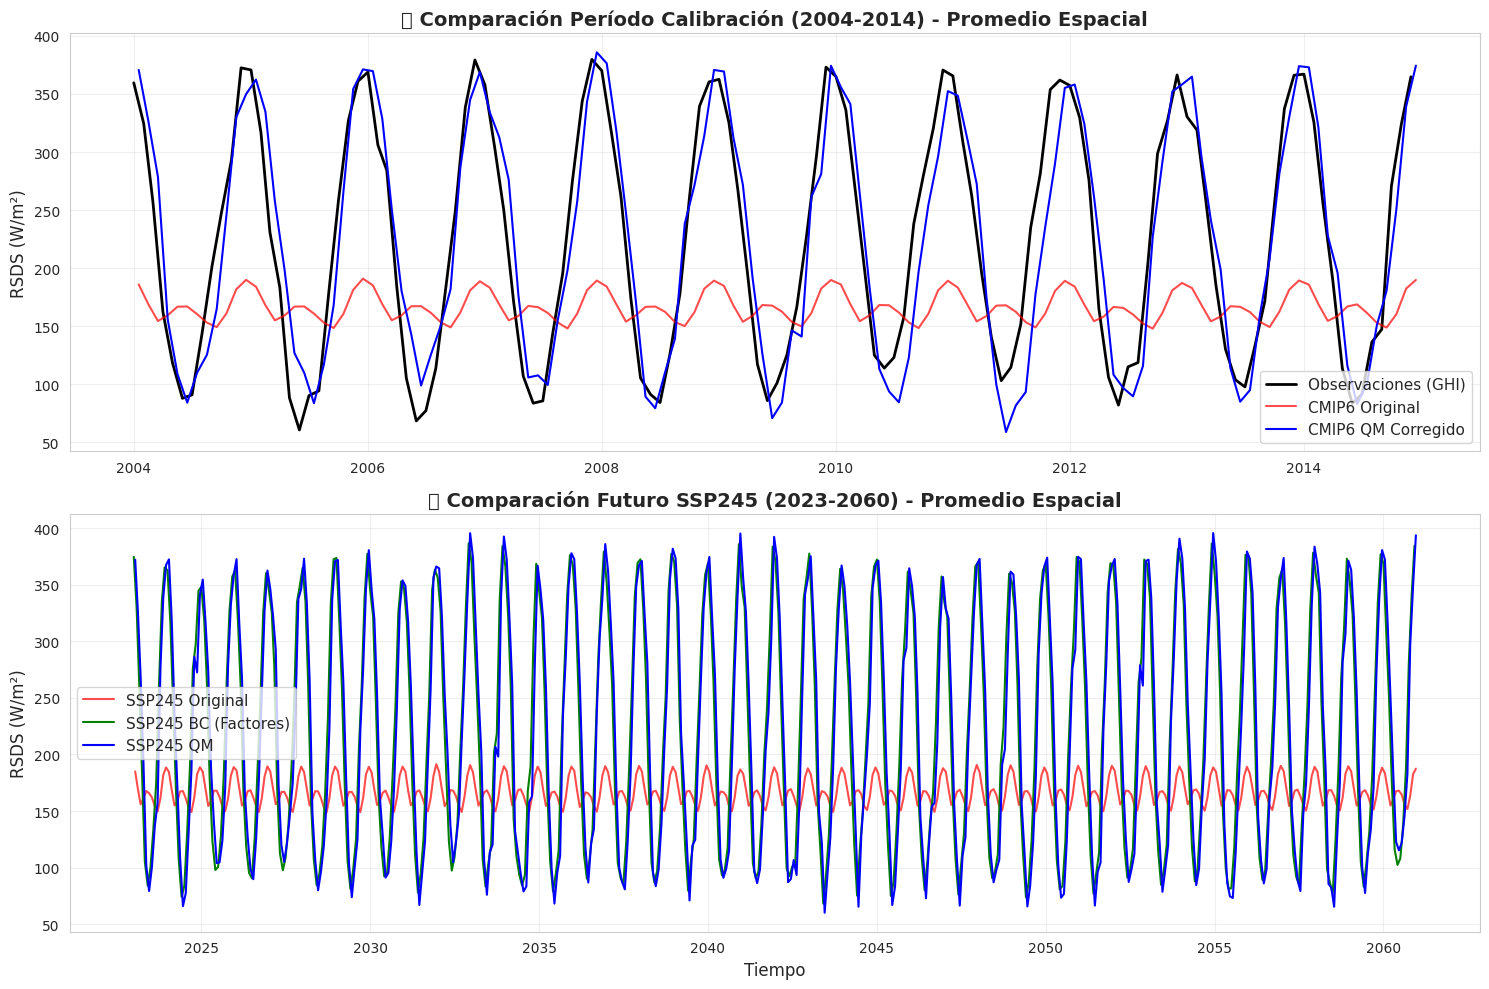


✅ Gráficos de series temporales completados


In [11]:
# ============================================================
# 🔍 ANÁLISIS 2: COMPARACIÓN VISUAL - SERIES TEMPORALES
# ============================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS 2: SERIES TEMPORALES AGREGADAS ESPACIALMENTE")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Subplot 1: Período de calibración (2004-2014)
ax1 = axes[0]
obs_calib.mean(['lat', 'lon']).plot(ax=ax1, label='Observaciones (GHI)', color='black', linewidth=2)
hist_calib.mean(['lat', 'lon']).plot(ax=ax1, label='CMIP6 Original', color='red', alpha=0.7, linewidth=1.5)
if hist_qm is not None:
    hist_qm_calib.mean(['lat', 'lon']).plot(ax=ax1, label='CMIP6 QM Corregido', color='blue', linewidth=1.5)
ax1.set_title('📊 Comparación Período Calibración (2004-2014) - Promedio Espacial', fontsize=14, fontweight='bold')
ax1.set_ylabel('RSDS (W/m²)', fontsize=12)
ax1.set_xlabel('')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Subplot 2: Futuro SSP245 (2023-2060)
ax2 = axes[1]
if ssp_orig is not None:
    ssp_orig.sel(time=slice('2023','2060')).mean(['lat', 'lon']).plot(
        ax=ax2, label='SSP245 Original', color='red', alpha=0.7, linewidth=1.5)
if ssp_bc1 is not None:
    ssp_bc1.sel(time=slice('2023','2060')).mean(['lat', 'lon']).plot(
        ax=ax2, label='SSP245 BC (Factores)', color='green', linewidth=1.5)
if ssp_qm is not None:
    ssp_qm.sel(time=slice('2023','2060')).mean(['lat', 'lon']).plot(
        ax=ax2, label='SSP245 QM', color='blue', linewidth=1.5)
ax2.set_title('📊 Comparación Futuro SSP245 (2023-2060) - Promedio Espacial', fontsize=14, fontweight='bold')
ax2.set_ylabel('RSDS (W/m²)', fontsize=12)
ax2.set_xlabel('Tiempo', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Gráficos de series temporales completados")


🔍 ANÁLISIS 3: COMPARACIÓN DE DISTRIBUCIONES (HISTOGRAMAS Y BOXPLOTS)


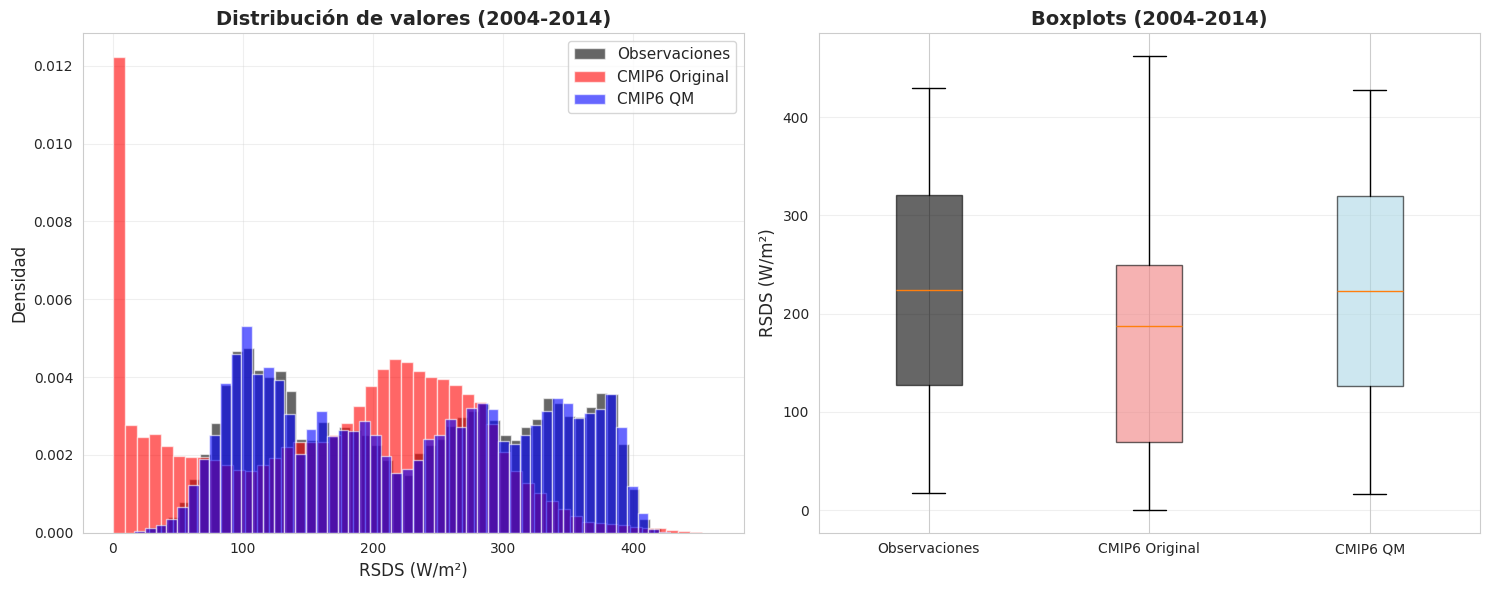


✅ Gráficos de distribuciones completados


In [12]:
# ============================================================
# 🔍 ANÁLISIS 3: DISTRIBUCIONES Y CUANTILES
# ============================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS 3: COMPARACIÓN DE DISTRIBUCIONES (HISTOGRAMAS Y BOXPLOTS)")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Histogramas
ax1 = axes[0]
obs_calib.values.flatten()[~np.isnan(obs_calib.values.flatten())].ravel()[:10000:10].tolist()
hist_vals_obs = obs_calib.values.flatten()
hist_vals_obs = hist_vals_obs[~np.isnan(hist_vals_obs)]
hist_vals_orig = hist_calib.values.flatten()
hist_vals_orig = hist_vals_orig[~np.isnan(hist_vals_orig)]

ax1.hist(hist_vals_obs, bins=50, alpha=0.6, label='Observaciones', color='black', density=True)
ax1.hist(hist_vals_orig, bins=50, alpha=0.6, label='CMIP6 Original', color='red', density=True)

if hist_qm is not None:
    hist_vals_qm = hist_qm_calib.values.flatten()
    hist_vals_qm = hist_vals_qm[~np.isnan(hist_vals_qm)]
    ax1.hist(hist_vals_qm, bins=50, alpha=0.6, label='CMIP6 QM', color='blue', density=True)

ax1.set_xlabel('RSDS (W/m²)', fontsize=12)
ax1.set_ylabel('Densidad', fontsize=12)
ax1.set_title('Distribución de valores (2004-2014)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Subplot 2: Boxplots
ax2 = axes[1]
box_data = [hist_vals_obs, hist_vals_orig]
box_labels = ['Observaciones', 'CMIP6 Original']

if hist_qm is not None:
    box_data.append(hist_vals_qm)
    box_labels.append('CMIP6 QM')

bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
colors = ['black', 'lightcoral', 'lightblue']
for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('RSDS (W/m²)', fontsize=12)
ax2.set_title('Boxplots (2004-2014)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Gráficos de distribuciones completados")

In [14]:
# ============================================================
# 🔍 DIAGNÓSTICO DETALLADO DE COORDENADAS Y ALINEACIÓN
# ============================================================

print("\n" + "="*70)
print("🔍 DIAGNÓSTICO DETALLADO: COORDENADAS Y ALINEACIÓN")
print("="*70)

if hist_qm is not None:
    print("\n📐 DIMENSIONES Y COORDENADAS:")
    print("\n1. Historical Original:")
    print(f"   • Shape: {hist_calib.shape}")
    print(f"   • Dims: {hist_calib.dims}")
    print(f"   • Coords: {list(hist_calib.coords)}")
    print(f"   • Lat range: {float(hist_calib.lat.min()):.4f} a {float(hist_calib.lat.max()):.4f}")
    print(f"   • Lon range: {float(hist_calib.lon.min()):.4f} a {float(hist_calib.lon.max()):.4f}")
    print(f"   • Time range: {hist_calib.time.min().values} a {hist_calib.time.max().values}")
    print(f"   • # timesteps: {len(hist_calib.time)}")
    
    print("\n2. Historical QM:")
    print(f"   • Shape: {hist_qm_calib.shape}")
    print(f"   • Dims: {hist_qm_calib.dims}")
    print(f"   • Coords: {list(hist_qm_calib.coords)}")
    print(f"   • Lat range: {float(hist_qm_calib.lat.min()):.4f} a {float(hist_qm_calib.lat.max()):.4f}")
    print(f"   • Lon range: {float(hist_qm_calib.lon.min()):.4f} a {float(hist_qm_calib.lon.max()):.4f}")
    print(f"   • Time range: {hist_qm_calib.time.min().values} a {hist_qm_calib.time.max().values}")
    print(f"   • # timesteps: {len(hist_qm_calib.time)}")
    
    print("\n🔍 PRUEBA DE ALINEACIÓN:")
    
    # Verificar si las coordenadas son idénticas
    lat_identical = np.allclose(hist_calib.lat.values, hist_qm_calib.lat.values, rtol=1e-5)
    lon_identical = np.allclose(hist_calib.lon.values, hist_qm_calib.lon.values, rtol=1e-5)
    time_identical = np.array_equal(hist_calib.time.values, hist_qm_calib.time.values)
    
    print(f"   • Latitudes idénticas: {'✅ SÍ' if lat_identical else '❌ NO'}")
    print(f"   • Longitudes idénticas: {'✅ SÍ' if lon_identical else '❌ NO'}")
    print(f"   • Tiempos idénticos: {'✅ SÍ' if time_identical else '❌ NO'}")
    
    if not lat_identical:
        print(f"\n   ⚠️ PROBLEMA DE LATITUDES:")
        print(f"      Original lat: {hist_calib.lat.values[:5]} ...")
        print(f"      QM lat: {hist_qm_calib.lat.values[:5]} ...")
    
    if not lon_identical:
        print(f"\n   ⚠️ PROBLEMA DE LONGITUDES:")
        print(f"      Original lon: {hist_calib.lon.values[:5]} ...")
        print(f"      QM lon: {hist_qm_calib.lon.values[:5]} ...")
    
    if not time_identical:
        print(f"\n   ⚠️ PROBLEMA DE TIEMPO:")
        print(f"      Original time: {hist_calib.time.values[:3]} ...")
        print(f"      QM time: {hist_qm_calib.time.values[:3]} ...")
    
    # Contar NaNs
    print(f"\n📊 VALORES NaN:")
    nan_orig = np.isnan(hist_calib.values).sum()
    nan_qm = np.isnan(hist_qm_calib.values).sum()
    total_vals = hist_calib.size
    
    print(f"   • Historical Original: {nan_orig}/{total_vals} NaN ({100*nan_orig/total_vals:.2f}%)")
    print(f"   • Historical QM: {nan_qm}/{total_vals} NaN ({100*nan_qm/total_vals:.2f}%)")
    
    # Intentar alinear manualmente si es necesario
    if not (lat_identical and lon_identical and time_identical):
        print(f"\n🔧 INTENTANDO ALINEACIÓN MANUAL...")
        try:
            # Interpolar QM a las coordenadas del original
            hist_qm_aligned = hist_qm_calib.interp(
                lat=hist_calib.lat,
                lon=hist_calib.lon,
                time=hist_calib.time,
                method='linear'
            )
            print("   ✅ Alineación manual exitosa")
            
            # Reemplazar hist_qm_calib con la versión alineada
            hist_qm_calib = hist_qm_aligned
            
        except Exception as e:
            print(f"   ❌ Error en alineación manual: {e}")
    
else:
    print("\n⚠️ No hay datos QM para diagnosticar")


🔍 DIAGNÓSTICO DETALLADO: COORDENADAS Y ALINEACIÓN

📐 DIMENSIONES Y COORDENADAS:

1. Historical Original:
   • Shape: (132, 144, 192)
   • Dims: ('time', 'lat', 'lon')
   • Coords: ['time', 'lat', 'lon']
   • Lat range: -89.3750 a 89.3750
   • Lon range: 0.9375 a 359.0625
   • Time range: 2004-01-16T12:00:00.000000000 a 2014-12-16T12:00:00.000000000
   • # timesteps: 132

2. Historical QM:
   • Shape: (132, 20, 20)
   • Dims: ('time', 'lat', 'lon')
   • Coords: ['time', 'lat', 'lon', 'variable']
   • Lat range: -33.2250 a -32.2750
   • Lon range: -71.8750 a -70.0250
   • Time range: 2004-01-16T12:00:00.000000000 a 2014-12-16T12:00:00.000000000
   • # timesteps: 132

🔍 PRUEBA DE ALINEACIÓN:


ValueError: operands could not be broadcast together with shapes (144,) (20,) 

In [13]:
# ============================================================
# 🔍 ANÁLISIS 4: COMPARACIÓN DIRECTA - ¿SON IGUALES?
# ============================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS 4: PRUEBA DE IGUALDAD DIRECTA")
print("="*70)

if hist_qm is not None:
    # Comparar valores numéricos directamente
    diff_hist = hist_qm_calib - hist_calib
    
    print("\n📊 Diferencia Historical QM - Historical Original:")
    print(f"   • Media de diferencias: {float(diff_hist.mean()):.4f} W/m²")
    print(f"   • Std de diferencias: {float(diff_hist.std()):.4f} W/m²")
    print(f"   • Max diferencia absoluta: {float(abs(diff_hist).max()):.4f} W/m²")
    print(f"   • % celdas con diferencia > 1 W/m²: {100*float((abs(diff_hist) > 1).sum() / diff_hist.size):.2f}%")
    print(f"   • % celdas con diferencia > 5 W/m²: {100*float((abs(diff_hist) > 5).sum() / diff_hist.size):.2f}%")
    
    # Test de igualdad numérica
    are_identical = np.allclose(hist_qm_calib.values, hist_calib.values, rtol=1e-5, atol=1e-8, equal_nan=True)
    
    if are_identical:
        print("\n⚠️ ¡ALERTA! Los datos corregidos y originales son NUMÉRICAMENTE IDÉNTICOS")
        print("   → Esto sugiere que la corrección NO se aplicó correctamente")
    else:
        print("\n✅ Los datos corregidos y originales SON DIFERENTES")
        print("   → La corrección se aplicó exitosamente")
else:
    print("\n⚠️ No hay datos QM para comparar")

# Comparar SSP245
if ssp_qm is not None and ssp_orig is not None:
    print("\n" + "-"*70)
    print("📊 Diferencia SSP245 QM - SSP245 Original (2023-2050):")
    
    ssp_orig_subset = ssp_orig.sel(time=slice('2023','2050'))
    ssp_qm_subset = ssp_qm.sel(time=slice('2023','2050'))
    
    diff_ssp = ssp_qm_subset - ssp_orig_subset
    
    print(f"   • Media de diferencias: {float(diff_ssp.mean()):.4f} W/m²")
    print(f"   • Std de diferencias: {float(diff_ssp.std()):.4f} W/m²")
    print(f"   • Max diferencia absoluta: {float(abs(diff_ssp).max()):.4f} W/m²")
    print(f"   • % celdas con diferencia > 1 W/m²: {100*float((abs(diff_ssp) > 1).sum() / diff_ssp.size):.2f}%")
    
    are_identical_ssp = np.allclose(ssp_qm_subset.values, ssp_orig_subset.values, rtol=1e-5, atol=1e-8, equal_nan=True)
    
    if are_identical_ssp:
        print("\n⚠️ ¡ALERTA! SSP245 corregido y original son NUMÉRICAMENTE IDÉNTICOS")
        print("   → La corrección NO se aplicó a los datos futuros")
    else:
        print("\n✅ SSP245 corregido y original SON DIFERENTES")
        print("   → La corrección se aplicó exitosamente a datos futuros")


🔍 ANÁLISIS 4: PRUEBA DE IGUALDAD DIRECTA

📊 Diferencia Historical QM - Historical Original:
   • Media de diferencias: nan W/m²
   • Std de diferencias: nan W/m²


ValueError: zero-size array to reduction operation fmax which has no identity

In [ ]:
# ============================================================
# 🔍 ANÁLISIS 5: MAPAS ESPACIALES DE DIFERENCIAS
# ============================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS 5: MAPAS ESPACIALES DE DIFERENCIAS")
print("="*70)

if hist_qm is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Calcular medias temporales para período de calibración
    obs_mean = obs_calib.mean('time')
    hist_orig_mean = hist_calib.mean('time')
    hist_qm_mean = hist_qm_calib.mean('time')
    
    # Mapa 1: Observaciones
    ax1 = axes[0, 0]
    obs_mean.plot(ax=ax1, cmap='YlOrRd', vmin=150, vmax=300)
    ax1.set_title('Observaciones (GHI) - Media 2004-2014', fontweight='bold')
    
    # Mapa 2: CMIP6 Original
    ax2 = axes[0, 1]
    hist_orig_mean.plot(ax=ax2, cmap='YlOrRd', vmin=150, vmax=300)
    ax2.set_title('CMIP6 Original - Media 2004-2014', fontweight='bold')
    
    # Mapa 3: CMIP6 QM Corregido
    ax3 = axes[1, 0]
    hist_qm_mean.plot(ax=ax3, cmap='YlOrRd', vmin=150, vmax=300)
    ax3.set_title('CMIP6 QM Corregido - Media 2004-2014', fontweight='bold')
    
    # Mapa 4: Diferencia QM - Original
    ax4 = axes[1, 1]
    diff_mean = hist_qm_mean - hist_orig_mean
    im = diff_mean.plot(ax=ax4, cmap='RdBu_r', vmin=-50, vmax=50)
    ax4.set_title('Diferencia: QM - Original (W/m²)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Estadísticos del mapa de diferencias:")
    print(f"   • Media: {float(diff_mean.mean()):.2f} W/m²")
    print(f"   • Std: {float(diff_mean.std()):.2f} W/m²")
    print(f"   • Max positivo: {float(diff_mean.max()):.2f} W/m²")
    print(f"   • Max negativo: {float(diff_mean.min()):.2f} W/m²")
else:
    print("\n⚠️ No hay datos QM para generar mapas")

In [ ]:
# ============================================================
# 📝 RESUMEN Y CONCLUSIONES
# ============================================================

print("\n" + "="*70)
print("📝 RESUMEN Y DIAGNÓSTICO FINAL")
print("="*70)

print("\n🔍 Verificación completada. Resumen de hallazgos:\n")

if hist_qm is not None:
    # Calcular diferencia promedio absoluta
    diff_abs_mean = float(abs(hist_qm_calib - hist_calib).mean())
    
    if diff_abs_mean < 0.01:
        print("❌ PROBLEMA DETECTADO:")
        print(f"   • Diferencia promedio absoluta: {diff_abs_mean:.6f} W/m²")
        print("   • Esto es extremadamente bajo, sugiere que NO se aplicó corrección")
        print("\n🔧 Posibles causas:")
        print("   1. El archivo 'corregido' es en realidad una copia del original")
        print("   2. Los parámetros de QM no se entrenaron correctamente")
        print("   3. El método .adjust() no se ejecutó sobre los datos")
        print("   4. Se guardó el archivo equivocado (original en lugar de corregido)")
        print("\n💡 Recomendación:")
        print("   • Re-ejecutar el notebook 02_correction_v2_qm.ipynb")
        print("   • Verificar que bc.adjust(sim=...) se ejecute correctamente")
        print("   • Imprimir estadísticos antes y después de adjust()")
    elif diff_abs_mean < 1.0:
        print("⚠️ CORRECCIÓN MENOR:")
        print(f"   • Diferencia promedio absoluta: {diff_abs_mean:.2f} W/m²")
        print("   • La corrección es muy sutil, puede ser normal si el modelo ya está bien calibrado")
        print("   • O puede indicar que el QM no está funcionando como esperado")
    else:
        print("✅ CORRECCIÓN APLICADA EXITOSAMENTE:")
        print(f"   • Diferencia promedio absoluta: {diff_abs_mean:.2f} W/m²")
        print("   • Los datos corregidos son claramente diferentes del original")
        print("   • El bias correction se aplicó correctamente")
else:
    print("⚠️ No se pudo realizar el diagnóstico completo")
    print("   • No se encontraron archivos de datos corregidos con QM")

print("\n" + "="*70)